In [1]:
import pandas as pd
import os

import numpy as np
import tqdm

import gensim
from gensim import models
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
import random

from pprint import pprint
import pickle 


import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk.stem as stemmer

from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS as stop_words

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')



[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1123)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1123)>
[nltk_data] Error loading words: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1123)>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify
[nltk_data]     failed: unable to get local issuer certificate
[nltk_data]     (_ssl.c:1123)>


False

In [2]:

speeches = pd.read_csv('./all_ECB_speeches.csv', delimiter='|', error_bad_lines=False)
speeches.tail()


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,date,speakers,title,subtitle,contents
2483,1997-05-13,Alexandre Lamfalussy,The European Central Bank: independent and acc...,Keynote speech delivered by Alexandre Lamfalus...,The European Central Bank: independent and a...
2484,1997-04-30,Alexandre Lamfalussy,The operation of monetary policy in stage thre...,"Address by Alexandre Lamfalussy, President of ...",The operation of monetary policy in stage th...
2485,1997-04-22,Alexandre Lamfalussy,Convergence and the role of the European Centr...,"Remarks by Alexandre Lamfalussy, President of ...",Convergence and the role of the European Cen...
2486,1997-03-10,Alexandre Lamfalussy,Securing the benefits of EMU,"Address by Alexandre Lamfalussy, President of ...",Securing the benefits of EMU Address by Al...
2487,1997-02-07,Alexandre Lamfalussy,Conference organised by the Hungarian Banking ...,"Address by Alexandre Lamfalussy, President of ...",Conference organised by the Hungarian Bankin...


In [3]:

#Remove NA entries
speeches = speeches.dropna()

print(len(speeches))
#Only get presidential speeches
# speeches = speeches.loc[speeches.subtitle.str.contains("\sPresident\s"),:]


#Regex cleaning
speeches['contents'] = speeches['contents'].replace('SPEECH', ' ', regex=True)
speeches['contents'] = speeches['contents'].replace('\s+', ' ', regex=True)
speeches['contents'] = speeches['contents'].replace('\(.*?\)', ' ', regex=True)
speeches['contents'] = speeches['contents'].replace('\[.*?\]', ' ', regex=True)
speeches['contents'] = speeches['contents'].replace('Note.*?\.', ' ', regex=True)
speeches['contents'] = speeches['contents'].replace('Chart .*?\..*?\.', ' ', regex=True)

speeches['contents'] = speeches['contents'].replace('I\..*?References', ' ', regex=True) #edge caSe
speeches['contents'] = speeches['contents'].replace('References.*', ' ', regex=True)
speeches['contents'] = speeches['contents'].replace('REFERENCES.*', ' ', regex=True)
speeches['contents'] = speeches['contents'].replace('LITERATURE.*', ' ', regex=True)
speeches['contents'] = speeches['contents'].replace('BIBLIOGRAPHY.*', ' ', regex=True)
speeches['contents'] = speeches['contents'].replace(' [0-9]\. ', ' ', regex=True)


speeches['contents'] = speeches['contents'].replace('Vol.*?pp.*?\.', ' ', regex=True)

speeches['contents'] = speeches['contents'].replace('Vol\..*?[0-9]*,.*?No\..*?\.', ' ', regex=True)


speeches['contents'] = speeches['contents'].replace('op\..*?cit\..*?\.', ' ', regex=True)
speeches['contents'] = speeches['contents'].replace('op\..*?cit\.', ' ', regex=True)


speeches['contents'] = speeches['contents'].replace('See.*?\.', ' ', regex=True)


speeches['contents'] = speeches['contents'].replace('SEE ALSO.*', ' ', regex=True)

speeches['contents'] = speeches['contents'].replace('Thank you\..*', ' ', regex=True)
speeches['contents'] = speeches['contents'].replace('Thank you for your kind attention\..*', ' ', regex=True)
speeches['contents'] = speeches['contents'].replace('Thank you for your attention\..*', ' ', regex=True)
speeches['contents'] = speeches['contents'].replace('I thank you for your attention\..*', ' ', regex=True)

# reove numbers?

2460


In [4]:

# stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
words = set(nltk.corpus.words.words())


# preprocessing functions
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(nltk.tokenize.word_tokenize(str(sentence)))

def remove_non_english(texts):
    return [[w for w in nltk.wordpunct_tokenize(" ".join(doc)) if w.lower() in words or not w.isalpha()] for doc in texts]

#financial ones
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

def remove_word_length(texts):
    return [[w for w in doc if len(w)>3] for doc in texts]

def lemmatize(texts):
    return [[ lemmatizer.lemmatize(w,pos='v') for w in doc] for doc in texts]

def stemming(texts):
    return [[nltk.ste.lemmatize(w,pos='v') for w in doc] for doc in texts]

def noun_only(texts):
    return [[word[0] for word in nltk.pos_tag(doc) if word[1] in ['NN','JJ','JJR','JJS','NNP','NNS']] for doc in texts]



def preprocess(input_data):
    data = input_data.contents.values.tolist()
    data.reverse()

    # data = [input_data.iloc[1].contents]

    data_words = list(sent_to_words(data))
    
    data_words = remove_non_english(data_words)
    data_words = remove_stopwords(data_words)
    data_words = remove_word_length(data_words)
    
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    bigram_mod = gensim.models.phrases.Phraser(bigram)

    def make_bigrams(texts):
        return [bigram_mod[doc] for doc in texts]

    data_words = make_bigrams(data_words)

    
    data_words = remove_stopwords(data_words)
    

    data_words = lemmatize(data_words)

    data_words = noun_only(data_words)

    

    return data_words



In [5]:
data_words = preprocess(speeches)

In [6]:
# get index range of speeches

quarters = ["(1|2|3)","(4|5|6)", "(7|8|9)","(10|11|12)"]
indices = []
for year in range(1997,2022):
    for index, quarter in enumerate(quarters):
        data = speeches.loc[speeches['date'].str.contains(str(year) + '-0?' + quarter + '-'), :]
        indices.append(len(data))
indices = indices[:-2]

/var/folders/j9/rqqkqhds231b5h_6lrr4xt6h0000gn/T/ipykernel_22710/1858205421.py:7: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  data = speeches.loc[speeches['date'].str.contains(str(year) + '-0?' + quarter + '-'), :]


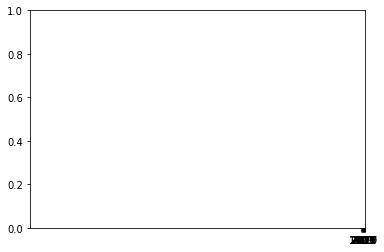

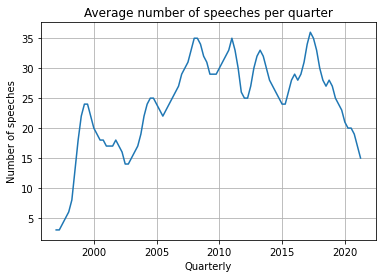

In [19]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.ndimage.filters import gaussian_filter1d

# Data for plotting

year = [[ year + index/4 for index in range (0, 4) ]for year in range(1997,2022)]
year = [item for sublist in year for item in sublist][:-2]

indices = gaussian_filter1d(indices, sigma=1.4)
plt.xticks(np.arange(1997, 2021, 2))

fig, ax = plt.subplots()
ax.plot(year, indices)

ax.set(xlabel='Quarterly', ylabel='Number of speeches',
       title='Average number of speeches per quarter')
ax.grid()

fig.savefig("num_speech_quarterly.png")
plt.show()

In [7]:
new_indices = []
for i in range(0,len(indices)):
    new_indices.append(sum(indices[:i+1]))
print(new_indices)

[2, 8, 10, 19, 26, 29, 40, 65, 89, 119, 140, 170, 186, 206, 223, 244, 261, 280, 295, 317, 338, 356, 364, 383, 397, 417, 428, 454, 470, 507, 522, 558, 577, 607, 622, 649, 670, 703, 720, 754, 781, 815, 842, 880, 911, 957, 987, 1022, 1050, 1086, 1107, 1141, 1167, 1209, 1234, 1270, 1304, 1356, 1371, 1406, 1420, 1455, 1474, 1510, 1541, 1584, 1611, 1650, 1671, 1703, 1726, 1757, 1779, 1804, 1821, 1865, 1889, 1922, 1943, 1978, 2012, 2058, 2088, 2128, 2158, 2186, 2206, 2242, 2272, 2298, 2315, 2349, 2369, 2384, 2404, 2431, 2450, 2460]


In [8]:
other_indices = [0] + new_indices

In [9]:
average_len_quarterly = []
for i in range(1, len(other_indices)):
    count = [len(item) for item in data_words[other_indices[i-1]:other_indices[i]]]
    average_len_quarterly.append(sum(count)/len(count))

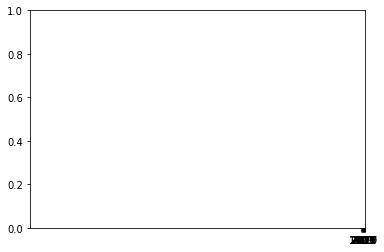

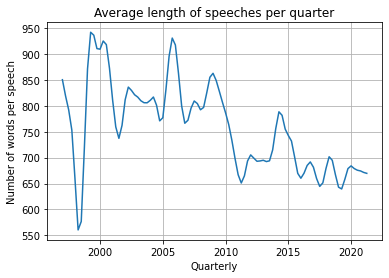

In [20]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.ndimage.filters import gaussian_filter1d

# Data for plotting

year = [[ year + index/4 for index in range (0, 4) ]for year in range(1997,2022)]
year = [item for sublist in year for item in sublist][:-2]

average_len_quarterly = gaussian_filter1d(average_len_quarterly, sigma=1.4)
plt.xticks(np.arange(1997, 2021, 2))

fig, ax = plt.subplots()
ax.plot(year, average_len_quarterly)

ax.set(xlabel='Quarterly', ylabel='Number of words per speech',
       title='Average length of speeches per quarter')
ax.grid()

fig.savefig("length_speech_quarterly.png")
plt.show()

In [11]:
# Create Dictionary
dictionary = corpora.Dictionary(data_words)
texts = data_words
texts_bow = [dictionary.doc2bow(text) for text in texts]
# dictionary.filter_extremes(no_below=30, no_above=0.3)


#hyperparm tune on the model
results = []
# 13 is 2000 q1 end
base = 12
import math


for index in range(base, len(new_indices)):
    print(f"{1997+int(math.floor(index/4))} Q{index%4}")
    # look back 4 quarters
    coherence_scroes = []
    

    corpus = texts_bow[new_indices[index-4]:new_indices[index]]

    tfidf = models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]

    for k in range(3,10):
        print(f"num_of_topics: {k}",end='\r')
        lda_model = gensim.models.LdaMulticore(corpus_tfidf, 
                                        num_topics=k, 
                                        id2word=dictionary,
                                        workers=4)
        coherence_model_lda = gensim.models.coherencemodel.CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_scroes.append(coherence_model_lda.get_coherence())
    
    results.append(coherence_scroes)


2000 Q0
2000 Q1
2000 Q2
2000 Q3
2001 Q0
2001 Q1
2001 Q2
2001 Q3
2002 Q0
2002 Q1
2002 Q2
2002 Q3
2003 Q0
2003 Q1
2003 Q2
2003 Q3
2004 Q0
2004 Q1
2004 Q2
2004 Q3
2005 Q0
2005 Q1
2005 Q2
2005 Q3
2006 Q0
2006 Q1
2006 Q2
2006 Q3
2007 Q0
2007 Q1
2007 Q2
2007 Q3
2008 Q0
2008 Q1
2008 Q2
2008 Q3
2009 Q0
2009 Q1
2009 Q2
2009 Q3
2010 Q0
2010 Q1
2010 Q2
2010 Q3
2011 Q0
2011 Q1
2011 Q2
2011 Q3
2012 Q0
2012 Q1
2012 Q2
2012 Q3
2013 Q0
2013 Q1
2013 Q2
2013 Q3
2014 Q0
2014 Q1
2014 Q2
2014 Q3
2015 Q0
2015 Q1
2015 Q2
2015 Q3
2016 Q0
2016 Q1
2016 Q2
2016 Q3
2017 Q0
2017 Q1
2017 Q2
2017 Q3
2018 Q0
2018 Q1
2018 Q2
2018 Q3
2019 Q0
2019 Q1
2019 Q2
2019 Q3
2020 Q0
2020 Q1
2020 Q2
2020 Q3
2021 Q0
2021 Q1


In [40]:

np_results = np.array(results)
print(np_results.shape)

(86, 7)


In [44]:
best_co_scores = np.max(np_results, axis=1)

In [45]:
best_ks = np.argmax(np_results, axis=1) +3

In [51]:
print(best_ks)

[3 3 4 3 3 3 3 3 3 3 3 4 4 3 4 3 3 4 3 3 3 3 4 3 3 3 3 3 3 3 3 4 3 5 4 3 4
 3 3 4 3 3 3 3 3 3 5 3 3 6 3 3 3 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 3 3 3 3 4 3
 3 3 3 3 3 5 3 6 3 3 3 3]


In [57]:
best_models = []
for index in range(base, len(new_indices)):
    print(f"{1997+int(math.floor(index/4))} Q{index%4}")
    # look back 4 quarters

    coherence_scroes = []
    

    corpus = texts_bow[new_indices[index-4]:new_indices[index]]

    tfidf = models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]

    lda_model = gensim.models.LdaMulticore(corpus_tfidf, 
                                    num_topics=best_ks[index-base], 
                                    id2word=dictionary,
                                    workers=4)

    best_models.append(lda_model)


2000 Q0
2000 Q1
2000 Q2
2000 Q3
2001 Q0
2001 Q1
2001 Q2
2001 Q3
2002 Q0
2002 Q1
2002 Q2
2002 Q3
2003 Q0
2003 Q1
2003 Q2
2003 Q3
2004 Q0
2004 Q1
2004 Q2
2004 Q3
2005 Q0
2005 Q1
2005 Q2
2005 Q3
2006 Q0
2006 Q1
2006 Q2
2006 Q3
2007 Q0
2007 Q1
2007 Q2
2007 Q3
2008 Q0
2008 Q1


In [ ]:
for index,item in enumerate(best_models):
    
    print(f"{1997+int(math.floor((index+base)/4))} Q{(index+base)%4}")
    pprint(item.print_topics())

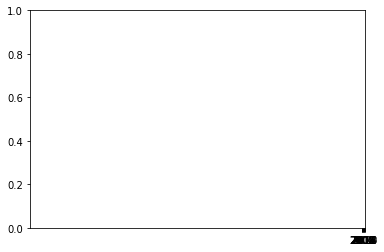

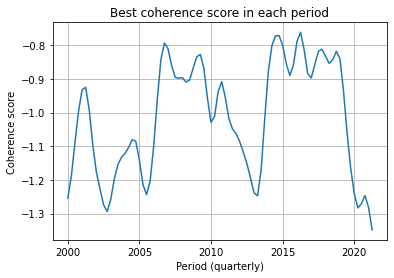

In [48]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.ndimage.filters import gaussian_filter1d

# Data for plotting
year = [[ year + index/4 for index in range (0, 4) ]for year in range(2000,2022)]
year = [item for sublist in year for item in sublist][:-2]

best_co_scores = gaussian_filter1d(best_co_scores, sigma=1.4)
plt.xticks(np.arange(2000, 2021, 2))

fig, ax = plt.subplots()
ax.plot(year, best_co_scores)

ax.set(xlabel='Period (quarterly)', ylabel='Coherence score',
       title='Best coherence score in each period')
ax.grid()

fig.savefig("best_co_period.png")
plt.show()

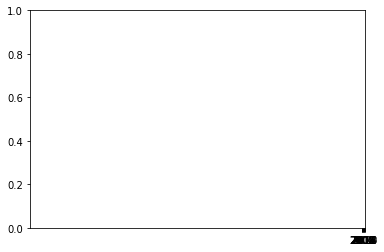

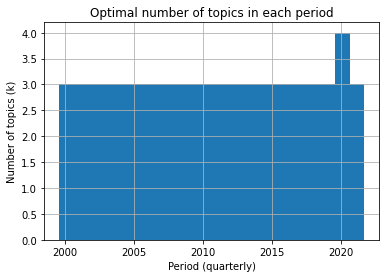

In [54]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.ndimage.filters import gaussian_filter1d

# Data for plotting
year = [[ year + index/4 for index in range (0, 4) ]for year in range(2000,2022)]
year = [item for sublist in year for item in sublist][:-2]

# best_co_scores = gaussian_filter1d(best_ks, sigma=1.4)
plt.xticks(np.arange(2000, 2021, 2))

fig, ax = plt.subplots()
ax.bar(year, height=best_co_scores)

ax.set(xlabel='Period (quarterly)', ylabel='Number of topics (k)',
       title='Optimal number of topics in each period')
ax.grid()

fig.savefig("best_ks.png")
plt.show()

In [12]:
import numpy as np
with open('idx.npy', 'wb') as f:
    np.save(f, np.array(new_indices))

with open('lda_results.npy', 'wb') as f:
    np.save(f, np.array(results))

In [23]:
overall_res = []
tfidf = models.TfidfModel(texts_bow)
corpus_tfidf = tfidf[texts_bow]
for k in range(3,20):
    print(f"num_of_topics: {k}")
    lda_model = gensim.models.LdaMulticore(corpus_tfidf, 
                                            num_topics=k, 
                                            id2word=dictionary,
                                            workers=4)
    coherence_model_lda = gensim.models.coherencemodel.CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='u_mass')
    overall_res.append(coherence_model_lda.get_coherence())

num_of_topics: 3
num_of_topics: 4
num_of_topics: 5
num_of_topics: 6
num_of_topics: 7
num_of_topics: 8
num_of_topics: 9
num_of_topics: 10
num_of_topics: 11
num_of_topics: 12
num_of_topics: 13
num_of_topics: 14
num_of_topics: 15
num_of_topics: 16
num_of_topics: 17
num_of_topics: 18
num_of_topics: 19


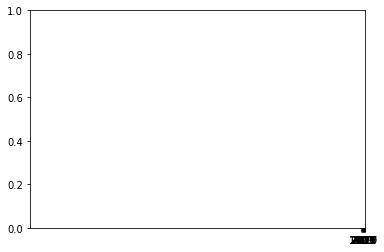

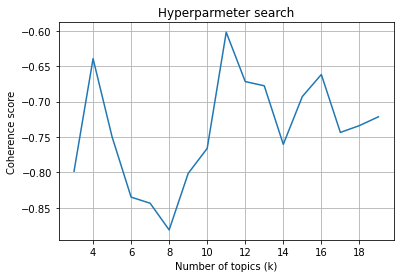

In [25]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.ndimage.filters import gaussian_filter1d

# Data for plotting

# average_len_quarterly = gaussian_filter1d(average_len_quarterly, sigma=1.4)
plt.xticks(np.arange(1997, 2021, 2))

fig, ax = plt.subplots()
ax.plot(range(3,20), overall_res)

ax.set(xlabel='Number of topics (k)', ylabel='Coherence score',
       title='Hyperparmeter search')
ax.grid()

fig.savefig("param_search_all.png")
plt.show()

In [29]:

dictionary = corpora.Dictionary(data_words)
texts = data_words
texts_bow = [dictionary.doc2bow(text) for text in texts]
lda_model = gensim.models.LdaMulticore(corpus_tfidf, 
                                            num_topics=11, 
                                            id2word=dictionary,
                                            workers=4)
coherence_model_lda = gensim.models.coherencemodel.CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='u_mass')
overall_res.append(coherence_model_lda.get_coherence())

In [31]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

def visualize(lda_model, corpus, id2word, mode, k=5):
    # Visualize the topics
    pyLDAvis.enable_notebook()
    LDAvis_data_filepath = os.path.join('ldavis_'+ mode +'_'+str(k))

    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

    # load the pre-prepared pyLDAvis data from disk
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)
    pyLDAvis.save_html(LDAvis_prepared,'ldavis_'+ mode +'_'+ str(k) +'.html')
    LDAvis_prepared

In [37]:
visualize(lda_model, tfidf, dictionary, "tfidf", 11)

TypeError: 'int' object is not iterable

In [ ]:
print(lda_model[tfidf[9]])
print(len(tfidf))

[(13, 0.93119437)]
735
